In [1]:
#QFT with swap static circuit

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi

def get_qft_circuit_static_swap(num_qubit):
    #Initialize the quantum circuit
    qr=QuantumRegister(num_qubit)
    cr3=ClassicalRegister(num_qubit,name="cr3")
    qc=QuantumCircuit(qr,cr3)
    
    # Apply the QFT
    for j in range(num_qubit):
        qc.h(j)
        for k in range(j + 1, num_qubit):
            qc.cp(pi / 2**(k - j), k, j)
    
    # Reverse the order of the qubits
    for i in range(num_qubit // 2):
        qc.swap(i, num_qubit - i - 1)

    #Final measurement
    for i in range(num_qubit):
        qc.measure(qr[i],cr3[i])
    
    return qc

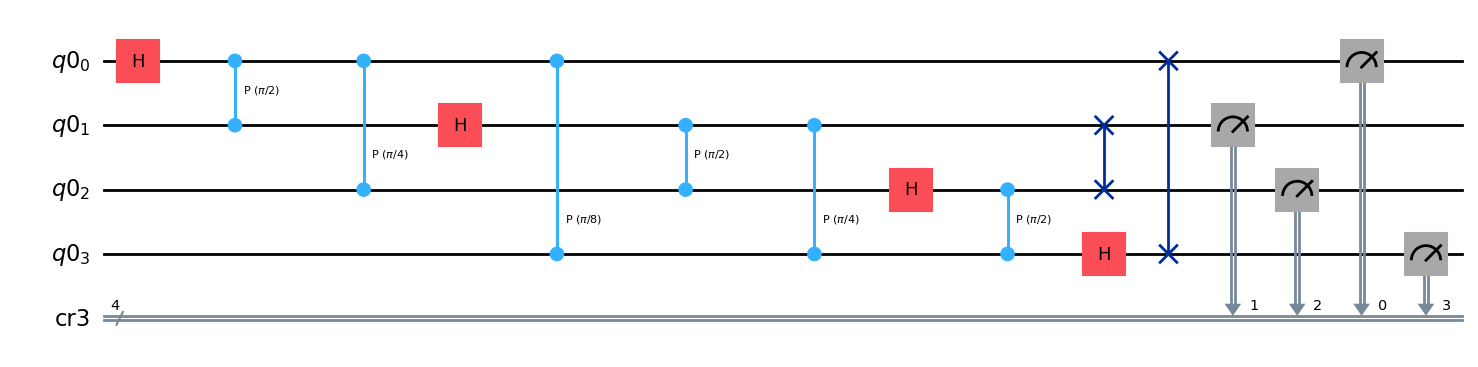

In [3]:
qc = get_qft_circuit_static_swap(num_qubit=4)
qc.draw('mpl')

In [4]:
#QFT with swap dynamic circuit

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.classical import expr
from math import pi

def get_qft_circuit_dynamic_swap(num_qubit):
    #Initialize the quantum circuit
    qr=QuantumRegister(num_qubit)
    cr1=ClassicalRegister(num_qubit,name="cr1")
    cr2=ClassicalRegister(num_qubit,name="cr2")
    qc=QuantumCircuit(qr,cr1,cr2)

    for j in range(num_qubit):
        qc.h(j)
        #Mid-circuit measurement
        qc.measure(qr[j],cr1[j])
        for k in range(j + 1, num_qubit):
            with qc.if_test((j, 1)):
                qc.p(pi / 2**(k - j), k)

    # Reverse the order of the qubits
    for i in range(num_qubit // 2):
        qc.swap(i, num_qubit - i - 1)

    qc.barrier()

    #Final measurement
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    
    return qc

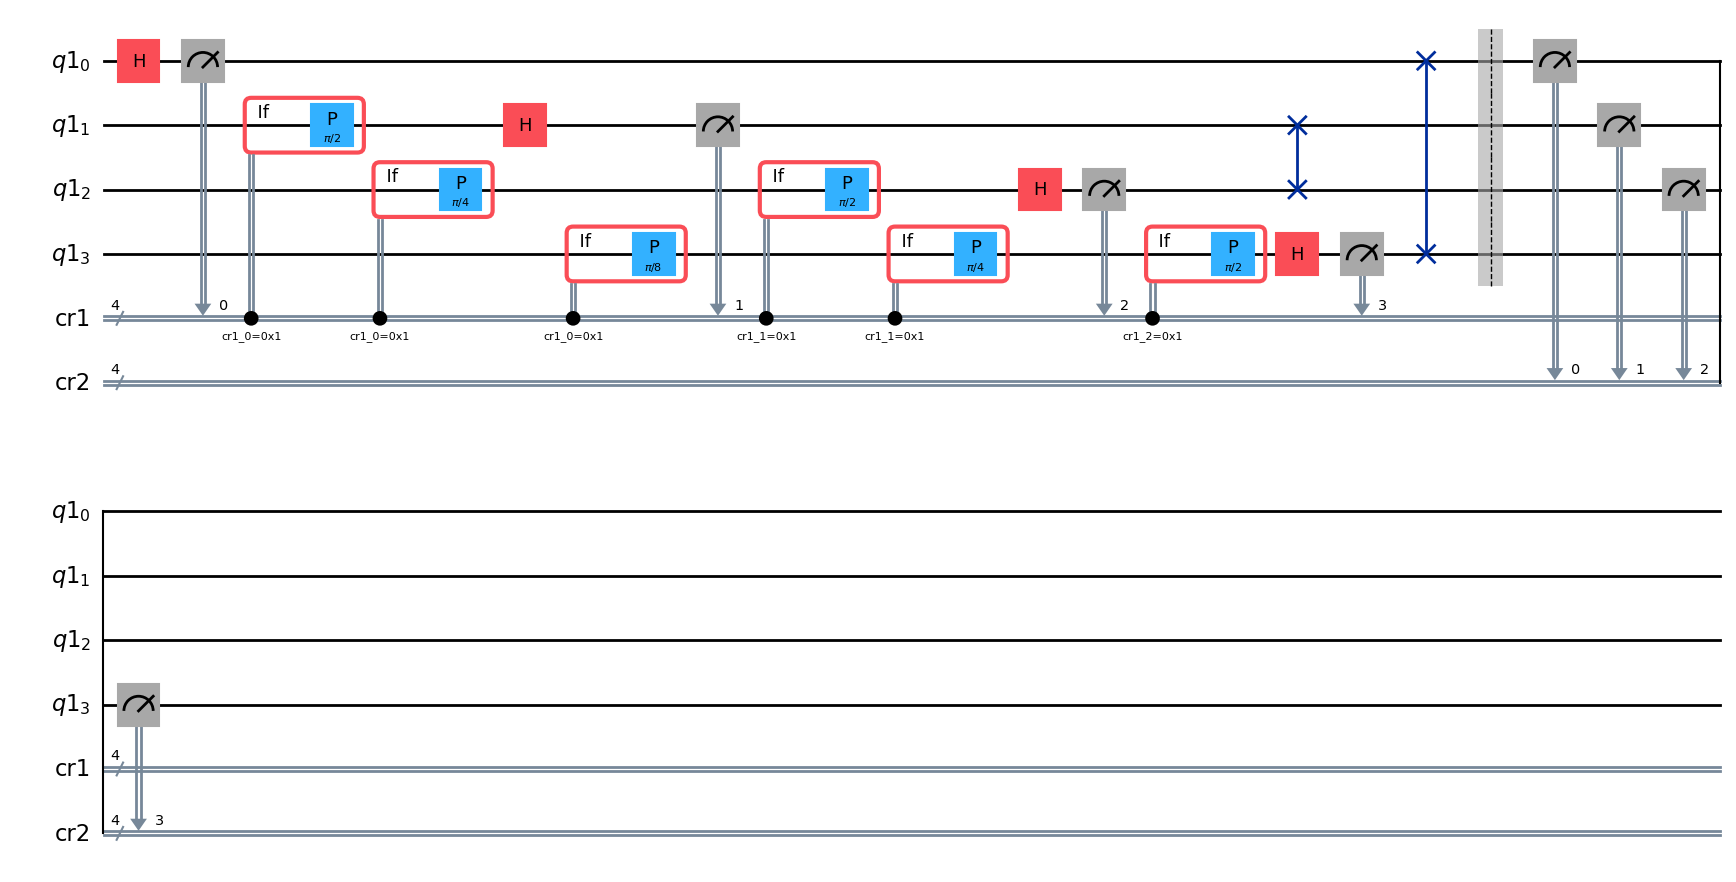

In [6]:
qc = get_qft_circuit_dynamic_swap(num_qubit=4)
qc.draw('mpl')

In [7]:
#Creating list of circuits[Static_1, Dynamic_1, Static_1, Dynamic_1,...,Static_2, Dynamic_2, Static_2, Dynamic_2,...] i.e. some copies of each of them

min_qubit=3
max_num_qubit=16
copies=3

#qc_list_static=[]
#qc_list_dynamic=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_qft_circuit_static_swap(num_qubit))
        qc_list.append(get_qft_circuit_dynamic_swap(num_qubit))
print(num_qubit_list)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [8]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, basis_gates=['snapshot', 'store', 'measure', 'barrier', 'h', 'cx'], translation_method='translator')
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [9]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [10]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots

84

In [11]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_swap = result_ideal[(2*i*copies)+(2*j)].data    
        data_dynamic_swap = result_ideal[(2*i*copies)+((2*j)+1)].data 

        print(data_static_swap)
        print(data_dynamic_swap)
        
        counts_static_swap=data_static_swap.cr3.get_counts()
        counts_dynamic_swap=data_dynamic_swap.cr2.get_counts()
        
        counts_list_ideal.append(counts_static_swap)
        counts_list_ideal.append(counts_dynamic_swap)

DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, 

In [12]:
#Transpilation in real hardware

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance="ibm-q/open/main")
service.backends()

[<IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_brisbane')>]

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

In [15]:
#Executing the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list,shots=1024)
print(job.job_id())

csxc4mjvkv50008hrpkg


In [12]:
#Post-processing
import matplotlib.pyplot as plt
import statistics
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'csxc4mjvkv50008hrpkg' #Brisbane

service = QiskitRuntimeService()
job = service.job(job_id)
result_real = job.result()

In [13]:
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(

84

In [14]:
# For getting list of real counts of IBM brisbane (argument required for Fidelity)
counts_list_real=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static_swap = result_real[(2*i*copies)+(2*j)].data    
        data_dynamic_swap = result_real[(2*i*copies)+((2*j)+1)].data 

        print(data_static_swap)
        print(data_dynamic_swap)
        
        counts_static_swap=data_static_swap.cr3.get_counts()
        counts_dynamic_swap=data_dynamic_swap.cr2.get_counts()
        
        counts_list_real.append(counts_static_swap)
        counts_list_real.append(counts_dynamic_swap)

DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=3>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=4>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr3=BitArray(<shape=(), num_shots=1024, num_bits=4>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, 

In [15]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_brisbane
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_static_swap_brisbane=[]
Fidelity_mean_dynamic_swap_brisbane=[]

Fidelity_std_static_swap_brisbane=[]
Fidelity_std_dynamic_swap_brisbane=[]

Fidelity_copies_static_swap_brisbane=[]
Fidelity_copies_dynamic_swap_brisbane=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):

        Fidelity_static_swap= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_real[(2*i*copies)+(2*j)])
        Fidelity_dynamic_swap=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_real[(2*i*copies)+((2*j)+1)])

        Fidelity_copies_static_swap_brisbane.append(Fidelity_static_swap)
        Fidelity_copies_dynamic_swap_brisbane.append(Fidelity_dynamic_swap)

    
    Fidelity_mean_static_swap_brisbane.append(statistics.mean(Fidelity_copies_static_swap_brisbane))
    Fidelity_mean_dynamic_swap_brisbane.append(statistics.mean(Fidelity_copies_dynamic_swap_brisbane))
    
    Fidelity_std_static_swap_brisbane.append(statistics.stdev(Fidelity_copies_static_swap_brisbane))
    Fidelity_std_dynamic_swap_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_swap_brisbane))
    
    Fidelity_copies_static_swap_brisbane.clear()
    Fidelity_copies_dynamic_swap_brisbane.clear()

[0.9929583007317129, 0.9094588681830688, 0.8886090405463499, 0.8996247891982296, 0.8196930054588413, 0.7694895720184749, 0.6132755098438578, 0.33730963430088046, 0.13172630269825308, 0.04355070202225337, 0.011811748728716601, 0.003226394891303618, 0.0011918808760588272, 0.0003035582505052745]
[0.9965182259392463, 0.9868401993351894, 0.9778742298283402, 0.9576769611117774, 0.9165978870669471, 0.807097113390398, 0.6256184371598198, 0.32868115369071543, 0.1452361048692193, 0.043447456278233015, 0.012023061906291616, 0.0038400154601181337, 0.0009646040019092708, 0.00026302241313288935]


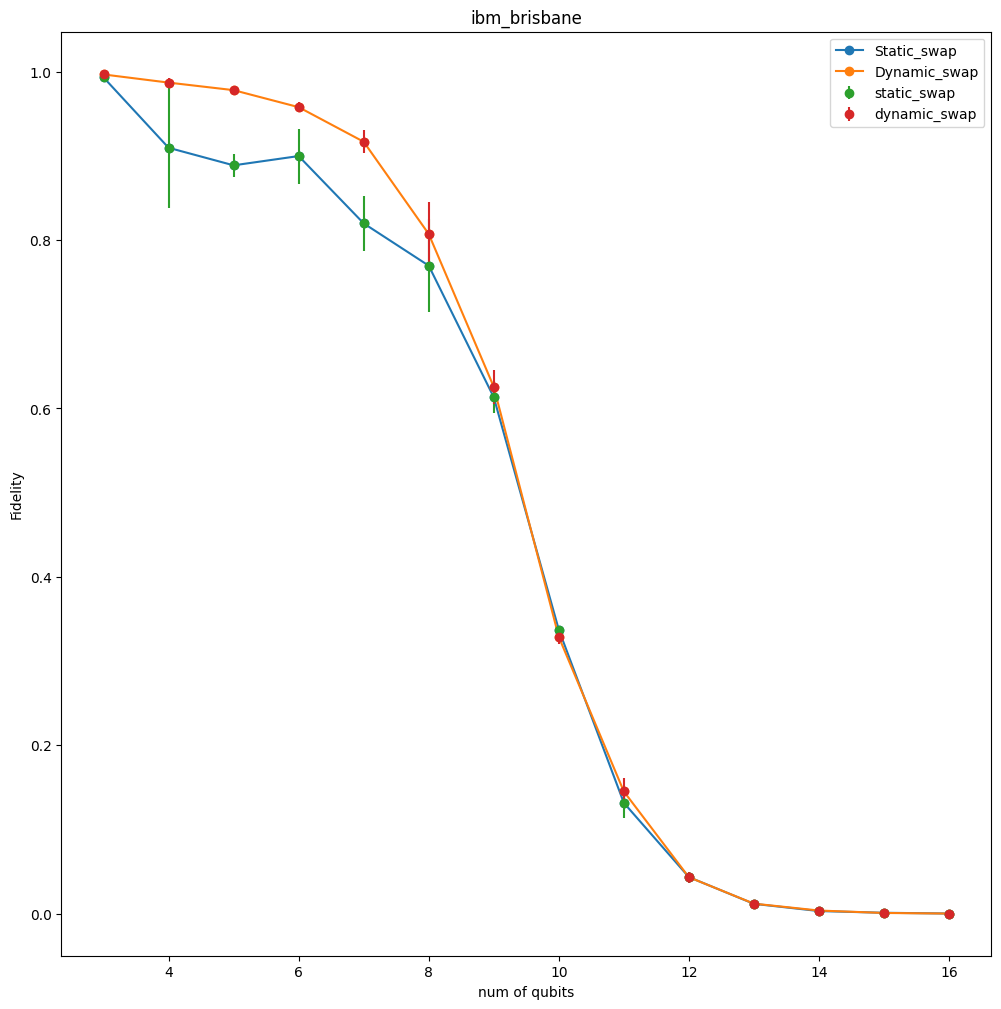

In [16]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax1 = plt.subplots(1, 1, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_static_swap = Fidelity_mean_static_swap_brisbane
y1_dynamic_swap = Fidelity_mean_dynamic_swap_brisbane
print(y1_static_swap)
print(y1_dynamic_swap)
y_error_static_swap =Fidelity_std_static_swap_brisbane
y_error_dynamic_swap =Fidelity_std_dynamic_swap_brisbane
ax1.plot(x1, y1_static_swap, 'o-',label='Static_swap')
ax1.plot(x1, y1_dynamic_swap, 'o-',label='Dynamic_swap')
ax1.errorbar(x1, y1_static_swap,
			yerr = y_error_static_swap, label='static_swap',
			fmt ='o')
ax1.errorbar(x1, y1_dynamic_swap,
			yerr = y_error_dynamic_swap, label='dynamic_swap',
			fmt ='o')


plt.legend()
plt.show()